## Imports & Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip, Grayscale, Normalize
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from helpers import *
from architecture.AutoEncoder import *
from torch.autograd import Variable

In [2]:
torch.manual_seed(969)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Prepare Dataset

In [4]:
size = 64
batch_size = 64
transformation = Compose([RandomHorizontalFlip(), Resize((size, size)), ToTensor()])

In [5]:
root = 'real_and_fake_face/train'
train_data = create_dataset(root, transformation)
data_loader = produce_loader(train_data, batch_size)

[441, 996, 1386, 26, 661, 958, 420, 1461, 150]


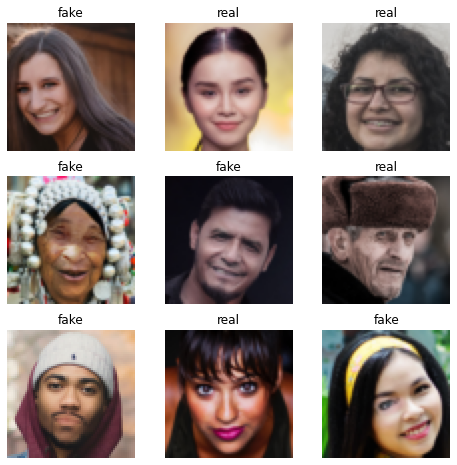

In [7]:
visualize_data(train_data)

## Initialize Autoencoder

In [8]:
def create_adam_optimizer(model, lr = 0.1, betas=(0.9, 0.999), amsgrad=False):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

In [9]:
# number of hidden layers and their sizes
hidden = [3, 32, 64, 128, 256]

# kernel size of convolution layers
kernel_size = 3

In [10]:
autoencmodel = AutoEncoder(hidden, kernel_size).to(device)
print(autoencmodel)

AutoEncoder(
  (enc_combined): Sequential(
    (0): Encoder(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (1): Encoder(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (2): Encoder(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (3): Encoder(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
  )
  (dec_combined): Seq

## Train the AutoEncoder

In [11]:
outputs_list = []
loss_list = []
criterion = nn.MSELoss()
optimizer = create_adam_optimizer(autoencmodel, lr=0.001)

In [12]:
num_epochs = 5
for epoch in range(num_epochs):
    for data in data_loader:
        
        # Send data to device
        img, label = data
        img = Variable(img).to(device)
        
        # Forward pass
        output = autoencmodel(img)
        loss = criterion(output, img)
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Display
    print('epoch {}/{}, loss {:.4f}'.format(epoch + 1, num_epochs, loss.item()))
    loss_list.append(loss.item())
    outputs_list.append((epoch, img, output, label),)

epoch 1/5, loss 0.0316
epoch 2/5, loss 0.0214
epoch 3/5, loss 0.0135
epoch 4/5, loss 0.0104
epoch 5/5, loss 0.0093


## Visualize AutoEncoder Outputs

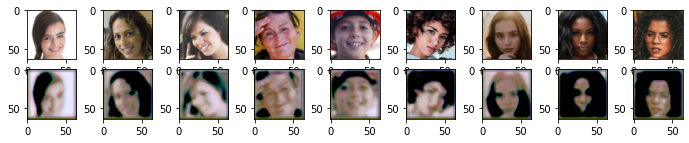

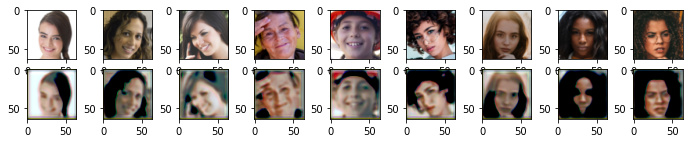

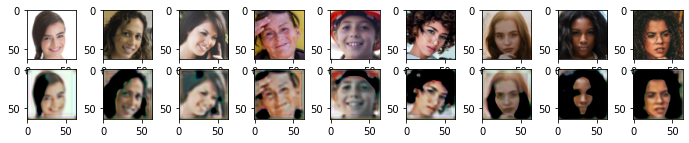

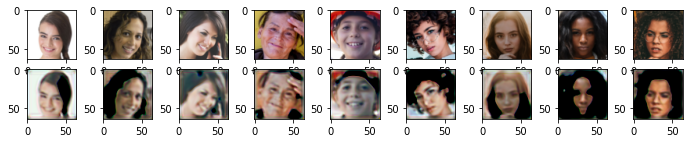

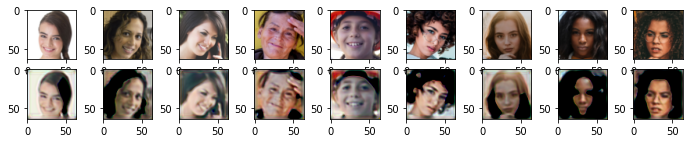

In [13]:
#display decoded images
import numpy as np
for k in range(num_epochs):
    plt.figure(figsize = (12, 2))
    imgs = outputs_list[k][1].cpu().detach().numpy()
    recon = outputs_list[k][2].cpu().detach().numpy()
    labels = outputs_list[k][3].cpu().detach().numpy()
    
    for i, item in enumerate(imgs):
        if i >= 9: break
        item = item.swapaxes(0,1)
        item = item.swapaxes(1,2)
        item = np.clip(item, 0, 1)
        plt.subplot(2, 9, i+1)
        plt.imshow(item)
        
    for i, item in enumerate(recon):
        if i >= 9: break
        item = item.swapaxes(0,1)
        item = item.swapaxes(1,2)
        item = np.clip(item, 0, 1)
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item)

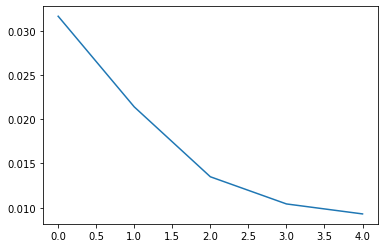

In [16]:
plt.figure()
plt.plot(loss_list)
plt.show()

In [17]:
single_loader = produce_loader(train_data, 1)
counter = 0
for param in autoencmodel.parameters():
    param.requiresGrad = False

In [19]:
for data in single_loader:
    img, label = data
    if label.item()==1:
        counter += 1
        img = img.to(device)
        output = autoencmodel(img)
        for _, item in enumerate(output):
            item = item.cpu().detach().numpy()
            item = item.swapaxes(0,1)
            item = item.swapaxes(1,2)
            item = np.clip(item, 0, 1)
            #plt.imshow(item)
            plt.imsave(f'./real_and_fake_face/train/fake/image_{counter}.jpg', item)
print("Done")

Done


In [20]:
root = 'real_and_fake_face/train'
check_data = create_dataset(root, transformation)

[1108, 1847, 2529, 2108, 362, 717, 1089, 2690, 885, 712, 1907, 1312, 2745, 2214, 2221, 3347, 2537, 1796, 511, 778, 348, 2459, 743, 1951, 46]


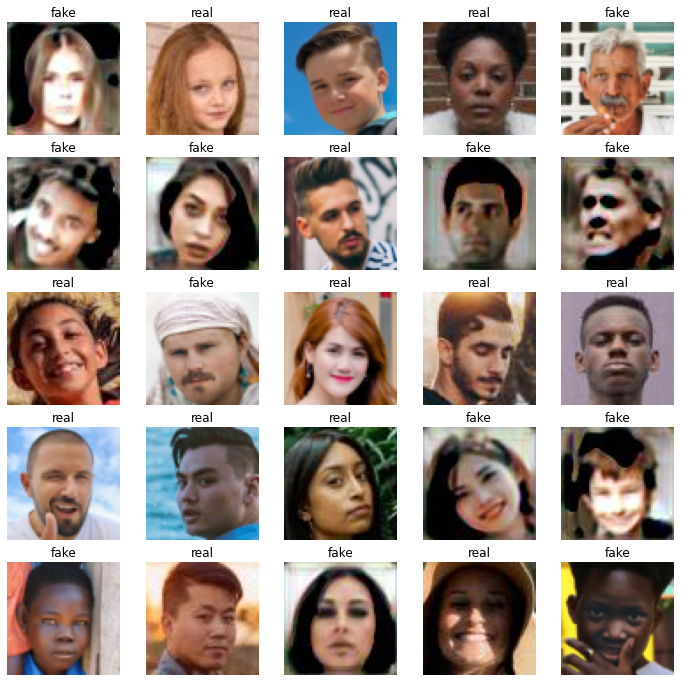

In [21]:
visualize_data(check_data, (12, 12), 5)

## Saving Model

In [22]:
torch.save({'model_state_dict': autoencmodel.state_dict(), 
            'optimizer_state_dict': optimizer.state_dict()}, 
           './_autoencoder256_5epochs')